In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import sklearn
import regex as re
import unicodedata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle

# Load Dataset

In [2]:
data = pd.read_csv('../data/train_preprocess.tsv', sep='\t', header=None)
alay_dict = pd.read_csv('../data/new_kamusalay.csv', encoding='latin-1', header=None)
stopword_dict = pd.read_csv('../data/stopwordbahasa.csv', header=None)
id_stopword_dict = stopword_dict.rename(columns={0: 'stopword'})

In [104]:
data.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [7]:
data['text'] = data[0]
data['label'] = data[1]
data = data.drop([0, 1], axis=1)
data['label'].value_counts()
data.dtypes

text     object
label    object
dtype: object

# Data Pre-processing

In [106]:
alay_dict.head()

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


## Text Normalization

In [3]:
import re
import unicodedata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text)
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text


def normalize_alay(text):
    alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))   
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\KHADHI MUSAID SYAH\AppData\Local\Temp\ipykernel_9436\2481707706.py:14: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL


In [4]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    text = remove_unicode(text)
    text = remove_extra_spaces(text)

    return text

In [8]:
data['cleaned_text'] = data.text.apply(preprocess)

In [110]:
data

,text,label,cleaned_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah ai diwlh s...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kakak kuning ajar...
...,...,...,...
10995,tidak kecewa,positive,kecewa
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,enak masakan nya kepiting senang pilih kepitin...
10997,hormati partai-partai yang telah berkoalisi,neutral,hormat ai ai koalisi
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi tol pasteur macet parah bikin jengkel


In [111]:
data['cleaned_text'].head()

0    warung milik usaha pabrik puluh kenal putih ba...
1    mohon ulama lurus k212 mmbri hujjah ai diwlh s...
2    lokasi strategis jalan sumatra bandung nya nya...
3    betapa bahagia nya unboxing paket barang nya b...
4    aduh mahasiswa sombong kasih kakak kuning ajar...
Name: cleaned_text, dtype: object

In [9]:
neg = data.loc[data['label'] == 'negative'].cleaned_text.tolist()
neu = data.loc[data['label'] == 'neutral'].cleaned_text.tolist()
pos = data.loc[data['label'] == 'positive'].cleaned_text.tolist()

neg_label = data.loc[data['label'] == 'negative'].label.tolist()
neu_label = data.loc[data['label'] == 'neutral'].label.tolist()
pos_label = data.loc[data['label'] == 'positive'].label.tolist()

In [10]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


# Feature Extraction

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('../pickle/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('../pickle/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [19]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('../pickle/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Splitting Dataset

In [77]:
from sklearn.model_selection import train_test_split

file = open("../pickle/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("../pickle/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [79]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Misalkan y_train adalah label kelas
print("y_train shape:", y_train.shape)
y_one_hot = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_one_hot), 
    y=y_one_hot
)

# Buat dictionary class_weight yang diharapkan Keras
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


y_train shape: (8800, 3)
Class weights: {0: 1.0662789288743488, 1: 3.2058287795992713, 2: 0.5713543695623945}


# Training / Modeling

In [14]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout

In [107]:
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

embed_dim = 100
units = 1000

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=4, batch_size=220, validation_data=(X_test, y_test), verbose=1, class_weight=class_weight_dict, callbacks=[es]) #callbacks=[es])

d:\binar-bootcamp\platinum_challenge\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/4
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5099 - loss: 1.0676 - val_accuracy: 0.5786 - val_loss: 0.9283
Epoch 2/4
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7118 - loss: 0.7258 - val_accuracy: 0.8059 - val_loss: 0.5142
Epoch 3/4
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8497 - loss: 0.3812 - val_accuracy: 0.8432 - val_loss: 0.4168
Epoch 4/4
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8928 - loss: 0.2654 - val_accuracy: 0.8423 - val_loss: 0.4389
Epoch 4: early stopping


In [98]:
pickle.dump(model, open("../pickle/model_LSTM.p", "wb"))

# Evaluation

## Confussion Matrix, Accuracy, F1, Recall, Precision

In [108]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       685
           1       0.65      0.85      0.74       233
           2       0.91      0.88      0.89      1282

    accuracy                           0.84      2200
   macro avg       0.79      0.83      0.81      2200
weighted avg       0.85      0.84      0.84      2200



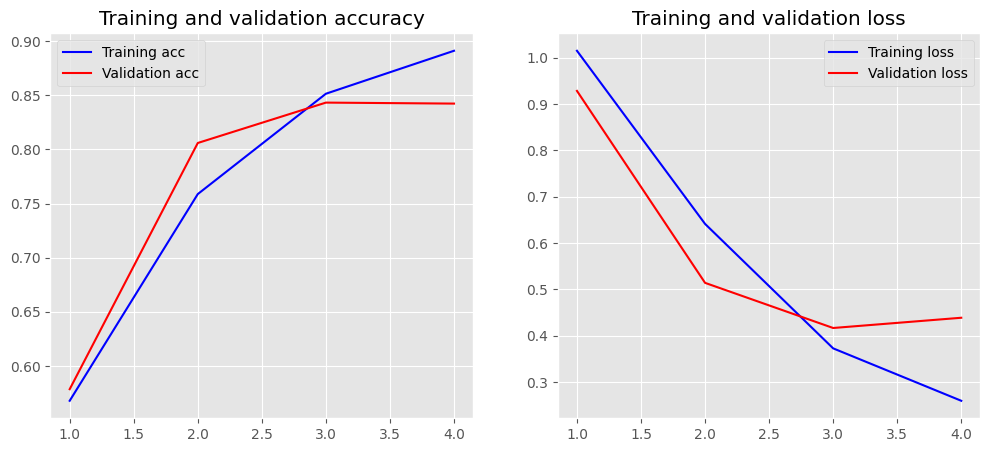

In [109]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

# Predict

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import regex as re
import unicodedata
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle

In [102]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text)
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text


def normalize_alay(text):
    alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))   
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\KHADHI MUSAID SYAH\AppData\Local\Temp\ipykernel_9436\1217008872.py:11: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL


In [113]:
import re
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_text = """
Peluncuran produk terbaru mengalami banyak kendala dan tidak sesuai dengan harapan. Banyak pelanggan mengeluhkan masalah kualitas, dan waktu pengiriman yang tertunda membuat kepercayaan terhadap perusahaan menurun. Ini adalah situasi yang sangat mengecewakan bagi semua pihak
"""

def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    text = remove_unicode(text)
    text = remove_extra_spaces(text)

    return text

sentiment = ['negative', 'neutral', 'positive']

file = open("../pickle/tokenizer.pickle",'rb')
tok = pickle.load(file)
file.close()

file = open("../pickle/model_LSTM.p",'rb')
model = pickle.load(file)
file.close() 

text = [preprocess(input_text)]
predicted = tok.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=77)

prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])
print("probability: ", np.max(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Text:  luncur produk alami kendala sesuai harap langgan keluh kualitas kirim te unda percaya hadap usaha turun situasi kecewa
Sentiment:  negative
probability:  0.9731357
